# Advanced Lane Finding Project - Data Analysis & Exploration

The overall goals of the Advanced Lane Line project include:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In this data analysis/exploration project, we explore data in each of the steps above and make decision towards our final solution for the project.

---
## 1. Camera Calibration

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# plot and save images
def plot_images(rows, cols, images_to_plot, titles_to_plot, out_file, cmap=None):
    fig = plt.figure(figsize=(6 * cols, 4 * rows))
    for idx in range(len(images_to_plot)):
        plt.subplot(rows, cols, idx+1)
        if cmap is not None and cmap[idx] is not None:
            plt.imshow(images_to_plot[idx], cmap=cmap[idx])
        else:
            plt.imshow(images_to_plot[idx])
        plt.title(titles_to_plot[idx])
    plt.tight_layout()
    fig.savefig('./output/' + out_file)
    plt.show()

# get the color mask
def color_mask(img, low, high):
    return cv2.inRange(img, low, high)

# calibrate camera
def calibrate_camera(images, nx, ny):

    objpoints = [] #3D object points
    imgpoints = [] #2D image points

    # prepare object points
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2) 

    for idx, fname in enumerate(images):

        # read image, BGR format in cv2
        img = cv2.imread(fname)
        
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, add to the list of imgpoints and objpoints
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    return cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# undistort image
def undistort_image(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

# unwarp image
def unwarp_image(img, src, dst):
    img_height, img_width = img.shape[:2]
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (img_width, img_height), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

images = glob.glob("./camera_cal/calibration*.jpg")
nx = 9 #enter the number of inside corners in x
ny = 6 #enter the number of inside corners in y
print("Calibrating camera ...")
ret, mtx, dist, rvecs, tvecs = calibrate_camera(images, nx, ny)
print("Done.")

Calibrating camera ...
Done.


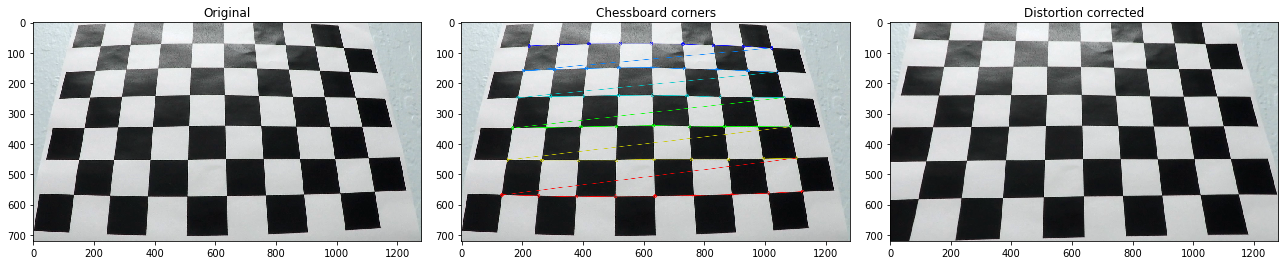

In [2]:
# camera calibration - steps
img = cv2.imread('./camera_cal/calibration3.jpg')
# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
if ret == True:
    corners_img = np.copy(img)
    cv2.drawChessboardCorners(corners_img, (nx, ny), corners, ret)
undist_img = undistort_image(img, mtx, dist)

# plot and save image
images_to_plot = [img, corners_img, undist_img]
titles_to_plot = ['Original', 'Chessboard corners', 'Distortion corrected']
out_file = "calibration.png"
plot_images(rows=1, cols=3, images_to_plot=images_to_plot, titles_to_plot=titles_to_plot, out_file=out_file)

## 2. Undistort Image

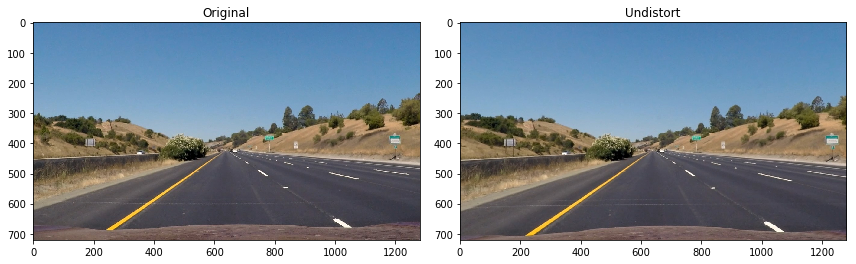

In [3]:
%matplotlib inline

# pick a test image
img = cv2.imread('./test_images/straight_lines1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

undist_img = undistort_image(img, mtx, dist)

# plot and save image
images_to_plot = [img, undist_img]
titles_to_plot = ['Original', 'Undistort']
out_file = "undistort.png"
plot_images(rows=1, cols=2, images_to_plot=images_to_plot, titles_to_plot=titles_to_plot, out_file=out_file)

## 3. Unwarp Image

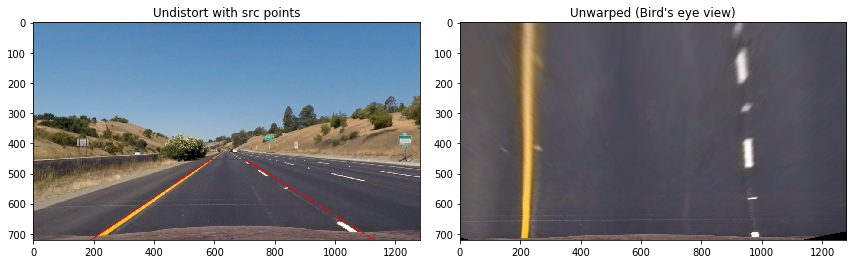

In [4]:
img_height, img_width = undist_img.shape[:2]

# source points
top_left = (585, 455)
top_right = (705, 455)
bottom_left = (190, 720)
bottom_right = (1130, 720)

src = np.float32([top_right,
                  bottom_right, 
                  bottom_left, 
                  top_left])

# desired destination
dst_top_left = (200, 0)
dst_top_right = (1000, 0)
dst_bottom_right = (1000, 720)
dst_bottom_left = (200, 720)

dst = np.float32([dst_top_right,
                  dst_bottom_right, 
                  dst_bottom_left, 
                  dst_top_left])

# unwarp image
unwarp_img, M, Minv = unwarp_image(undist_img, src, dst)

# draw lines for the source points
undist_img_copy = np.copy(undist_img)
cv2.line(undist_img_copy, (bottom_left[0], bottom_left[1]), (bottom_right[0], bottom_right[1]), color=(255,0,0), thickness=2)
cv2.line(undist_img_copy, (bottom_right[0], bottom_right[1]), (top_right[0], top_right[1]), color=(255,0,0), thickness=2)
cv2.line(undist_img_copy, (top_right[0], top_right[1]), (top_left[0], top_left[1]), color=(255,0,0), thickness=2)
cv2.line(undist_img_copy, (top_left[0], top_left[1]), (bottom_left[0], bottom_left[1]), color=(255,0,0), thickness=2)

# plot and save image
images_to_plot = [undist_img_copy, unwarp_img]
titles_to_plot = ['Undistort with src points', "Unwarped (Bird's eye view)"]
out_file = "unwarped.png"
plot_images(rows=1, cols=2, images_to_plot=images_to_plot, titles_to_plot=titles_to_plot, out_file=out_file)

## 4. Color Channels Thresholding

### 4.1 Image Comparison (in different color channels)

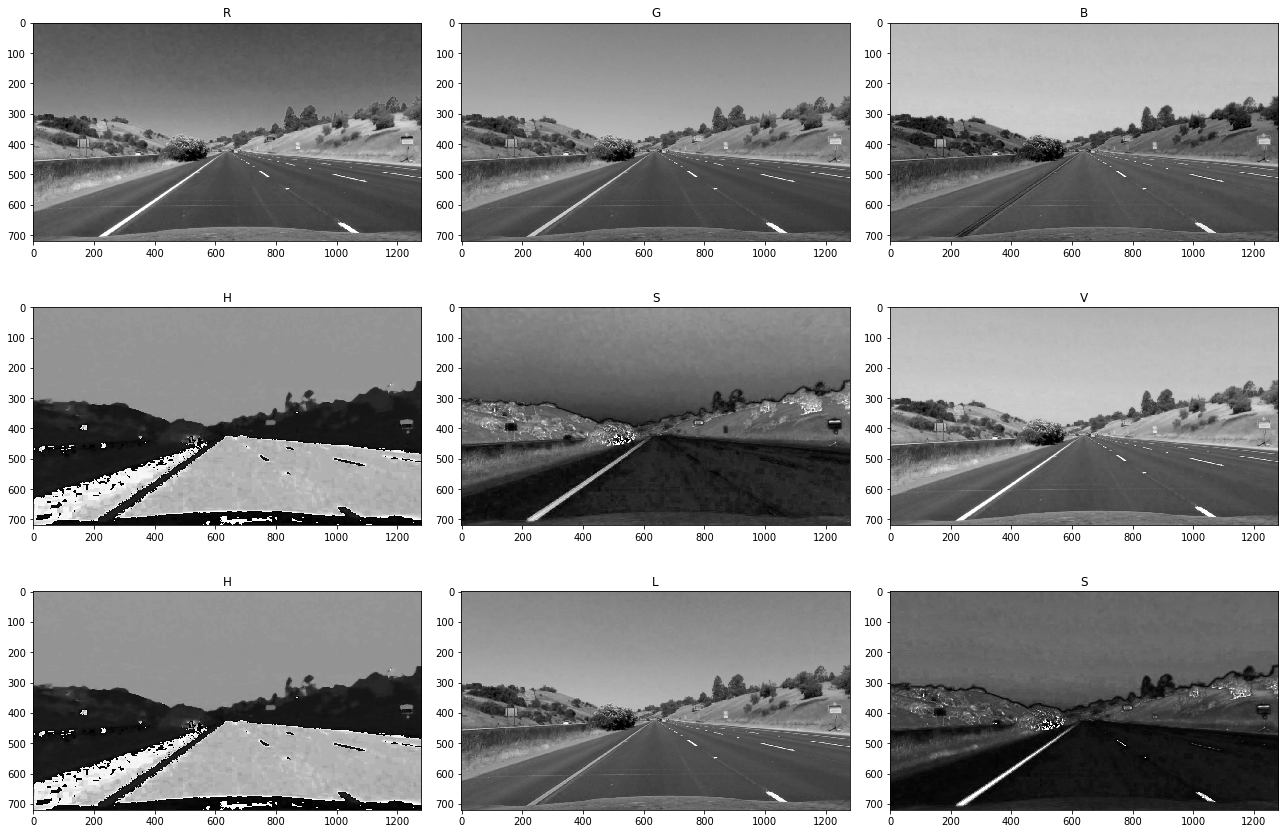

In [5]:
def plot_image_color_spaces(img_RGB):
    # setup image channels
    img_R = img_RGB[:,:,0]
    img_G = img_RGB[:,:,1]
    img_B = img_RGB[:,:,2]
    img_HSV = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2HSV)
    img_H = img_HSV[:,:,0]
    img_S = img_HSV[:,:,1]
    img_V = img_HSV[:,:,2]
    img_HLS = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2HLS)
    img_H1 = img_HLS[:,:,0]
    img_L1 = img_HLS[:,:,1]
    img_S1 = img_HLS[:,:,2]
    
    # plot and save image
    images_to_plot = [img_R, img_G, img_B, img_H, img_S, img_V, img_H1, img_L1, img_S1]
    titles_to_plot = ['R','G','B','H','S','V','H','L','S']
    cmap_gray=['gray','gray','gray','gray','gray','gray','gray','gray','gray']
    out_file = "color_channels.png"
    plot_images(rows=3, cols=3, images_to_plot=images_to_plot, titles_to_plot=titles_to_plot, out_file=out_file, cmap=cmap_gray)
    
plot_image_color_spaces(undist_img)

### 4.2 RGB Colorspace

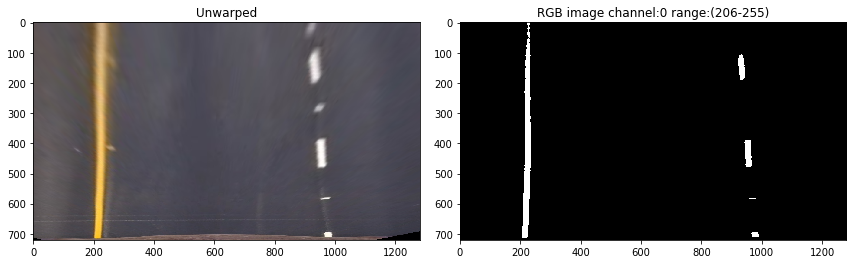

In [6]:
from ipywidgets import interact, interactive, fixed

def select(img, ch, thresh):
    channel = img[:,:,ch]
    out = np.zeros_like(channel)
    out[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    return out

def updateRGB(ch, thresh_min, thresh_max):
    out_img = select(unwarp_img, ch, thresh=(thresh_min, thresh_max))
    
    # plot and save image
    images_to_plot = [unwarp_img, out_img]
    titles_to_plot = ['Unwarped', 'RGB image channel:{} range:({}-{})'.format(ch, thresh_min, thresh_max)]
    out_file = "colorspace_RGB_{}.png".format(ch)
    plot_images(rows=1, cols=2, images_to_plot=images_to_plot, titles_to_plot=titles_to_plot, out_file=out_file, cmap=[None,'gray'])

interact(updateRGB, 
         ch=(0,2),
         thresh_min=(0,255),
         thresh_max=(0,255))

### 4.3 HSV Colorspace

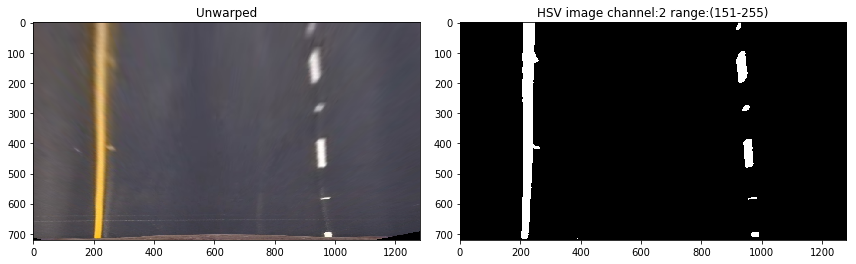

In [7]:
hsv = cv2.cvtColor(unwarp_img, cv2.COLOR_RGB2HSV)

def updateHSV(ch, thresh_min, thresh_max):
    out_img = select(hsv, ch, thresh=(thresh_min, thresh_max))

    # plot and save image
    images_to_plot = [unwarp_img, out_img]
    titles_to_plot = ['Unwarped', 'HSV image channel:{} range:({}-{})'.format(ch, thresh_min, thresh_max)]
    out_file = "colorspace_HSV_{}.png".format(ch)
    plot_images(rows=1, cols=2, images_to_plot=images_to_plot, titles_to_plot=titles_to_plot, out_file=out_file, cmap=[None,'gray'])

interact(updateHSV, 
         ch=(0,2),
         thresh_min=(0,255),
         thresh_max=(0,255))

### 4.4 HLS Colorspace

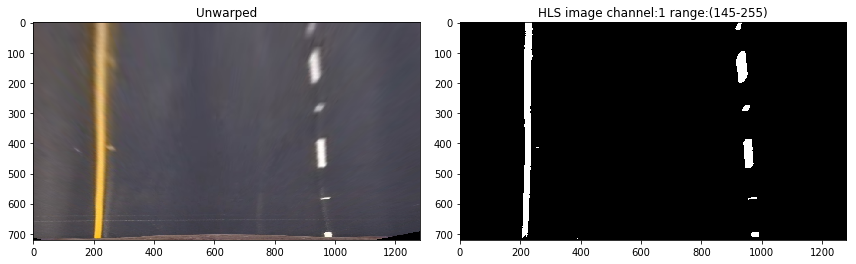

In [8]:
hls = cv2.cvtColor(unwarp_img, cv2.COLOR_RGB2HLS)

def updateHLS(ch, thresh_min, thresh_max):
    out_img = select(hls, ch, thresh=(thresh_min, thresh_max))

    # plot and save image
    images_to_plot = [unwarp_img, out_img]
    titles_to_plot = ['Unwarped', 'HLS image channel:{} range:({}-{})'.format(ch, thresh_min, thresh_max)]
    out_file = "colorspace_HLS_{}.png".format(ch)
    plot_images(rows=1, cols=2, images_to_plot=images_to_plot, titles_to_plot=titles_to_plot, out_file=out_file, cmap=[None,'gray'])

interact(updateHLS, 
         ch=(0,2),
         thresh_min=(0,255),
         thresh_max=(0,255))

### 4.5 Yellow color lane mask

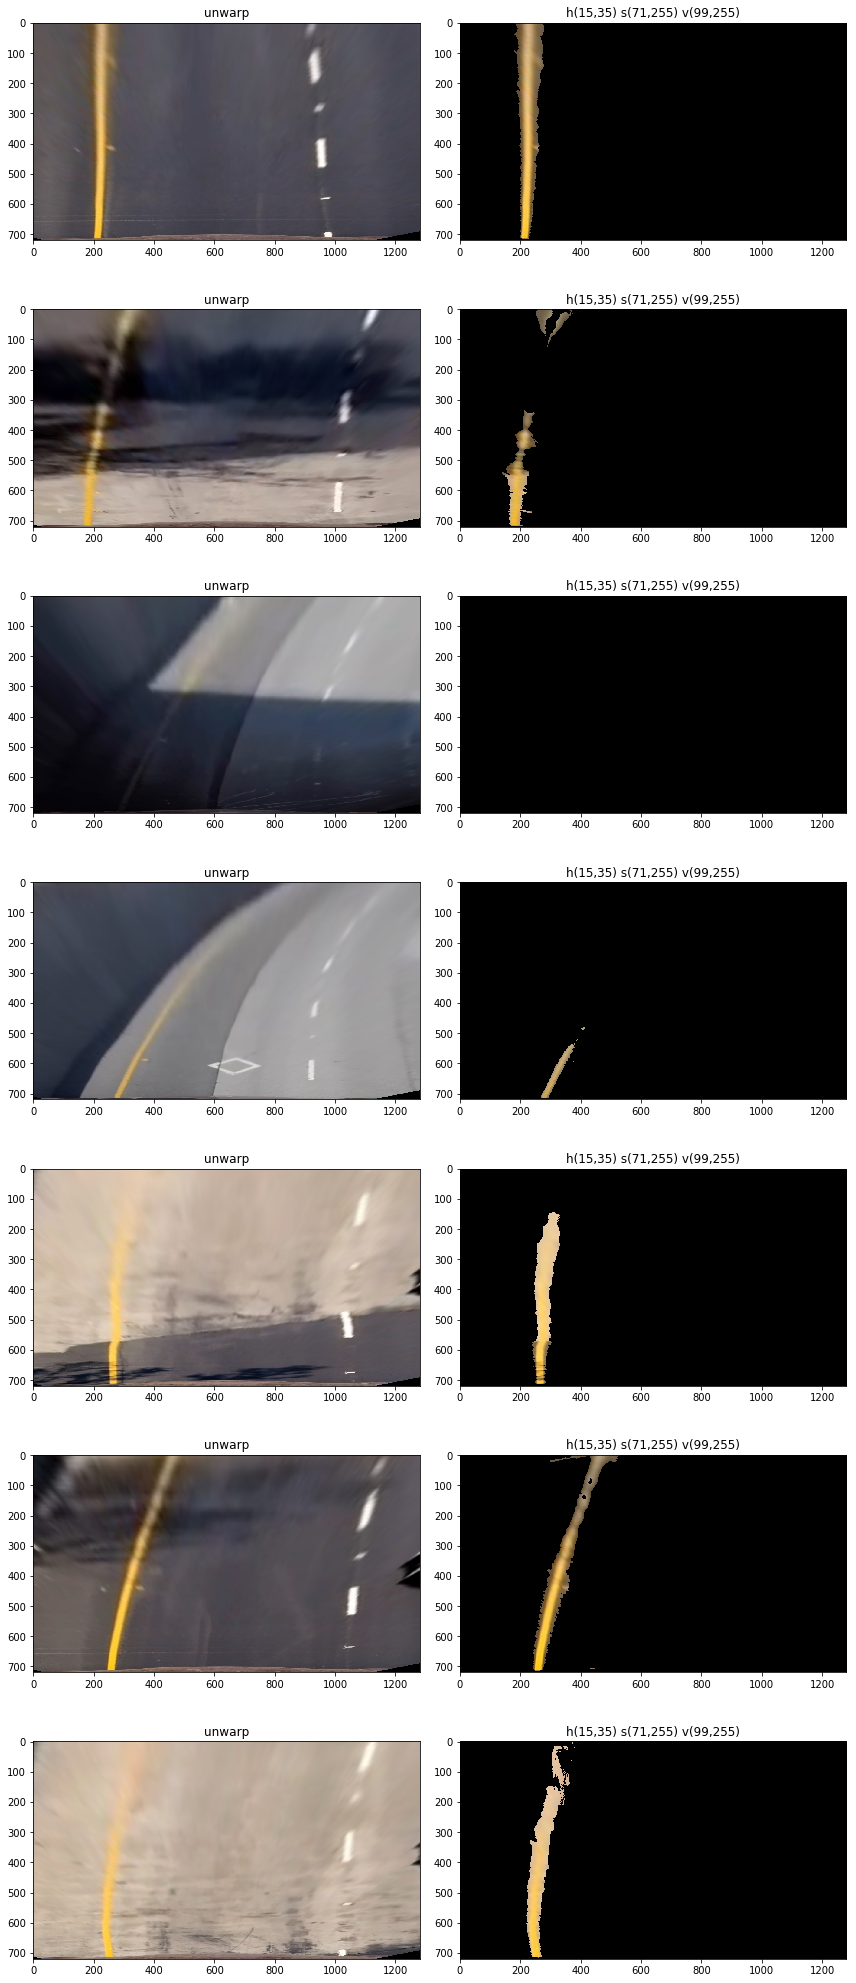

In [9]:
sample_filename_list = ['./test_images/straight_lines1.jpg', './test_images/test5.jpg', './new_test/org_134.jpg', './new_test/org_195.jpg', './test_images/test4.jpg','./test_images/test6.jpg','./test_images/test1.jpg']

def get_samples_rgb(image_filename_list):
    out_images = []
    for image_filename in image_filename_list:
        img = cv2.imread(image_filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        out_images.append(img)
    return out_images

def get_samples_unwarp(rgb_images, mtx, dist, src, dst):
    out_unwarp = []
    out_undist = []
    out_M = []
    out_Minv = []
    for image in rgb_images:
        undist_img = undistort_image(image, mtx, dist)
        unwarp_img, M, Minv = unwarp_image(undist_img, src, dst)
        out_unwarp.append(unwarp_img)
        out_undist.append(undist_img)
        out_M.append(M)
        out_Minv.append(Minv)
    return out_unwarp, out_undist, out_M, out_Minv

samples_rgb = get_samples_rgb(sample_filename_list)
samples_unwarp, samples_undist, samples_M, samples_Minv = get_samples_unwarp(samples_rgb, mtx, dist, src, dst)

def updateHSVYellow(ch0_min, ch0_max, ch1_min, ch1_max, ch2_min, ch2_max):
    
    yellow_hsv_low  = np.array([ch0_min, ch1_min, ch2_min])
    yellow_hsv_high = np.array([ch0_max, ch1_max, ch2_max])

    images_to_plot = []
    titles_to_plot = []
    cmaps_to_plot = []
    for idx in range(len(samples_unwarp)):
        sample_unwarp = samples_unwarp[idx]
        hsv = cv2.cvtColor(sample_unwarp, cv2.COLOR_RGB2HSV)
        mask = color_mask(hsv, yellow_hsv_low, yellow_hsv_high)
        image = np.copy(sample_unwarp)
        out_img = cv2.bitwise_and(image, image, mask= mask)
        images_to_plot.append(sample_unwarp)
        images_to_plot.append(out_img)
        titles_to_plot.append('unwarp')
        titles_to_plot.append('h({},{}) s({},{}) v({},{})'.format(ch0_min, ch0_max, ch1_min, ch1_max, ch2_min, ch2_max))
        cmaps_to_plot.append(None)
        cmaps_to_plot.append(None)
        
    # plot and save image
    out_file = "hsv_yellow_masked.png"
    plot_images(rows=len(sample_filename_list), cols=2, images_to_plot=images_to_plot, titles_to_plot=titles_to_plot, out_file=out_file, cmap=cmaps_to_plot)

interact(updateHSVYellow, 
         ch0_min=(0,255),
         ch0_max=(0,255),
         ch1_min=(0,255),
         ch1_max=(0,255),
         ch2_min=(0,255),
         ch2_max=(0,255))

### 4.6 White color lane mask¶

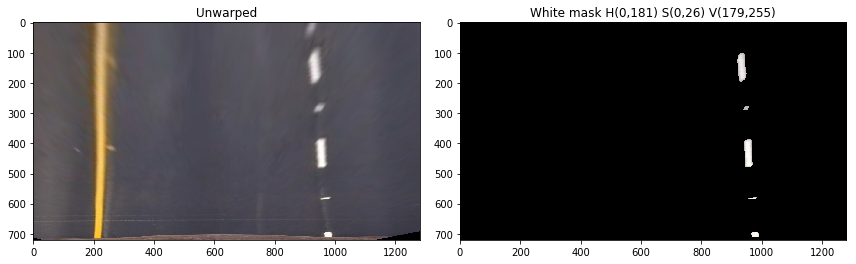

In [10]:
hsv = cv2.cvtColor(unwarp_img, cv2.COLOR_RGB2HSV)

def updateHSVWhite(ch0_min, ch0_max, ch1_min, ch1_max, ch2_min, ch2_max):
    image = np.copy(unwarp_img)
    white_hsv_low  = np.array([ch0_min, ch1_min, ch2_min])
    white_hsv_high = np.array([ch0_max, ch1_max, ch2_max])
    mask = color_mask(hsv, white_hsv_low, white_hsv_high)
    out_img = cv2.bitwise_and(image, image, mask= mask)

    # plot and save image
    images_to_plot = [unwarp_img, out_img]
    titles_to_plot = ['Unwarped', 'White mask H({},{}) S({},{}) V({},{})'.format(ch0_min, ch0_max, ch1_min, ch1_max, ch2_min, ch2_max)]
    out_file = "hsv_white_masked.png"
    plot_images(rows=1, cols=2, images_to_plot=images_to_plot, titles_to_plot=titles_to_plot, out_file=out_file, cmap=[None,None])

interact(updateHSVWhite, 
         ch0_min=(0,255),
         ch0_max=(0,255),
         ch1_min=(0,255),
         ch1_max=(0,255),
         ch2_min=(0,255),
         ch2_max=(0,255))

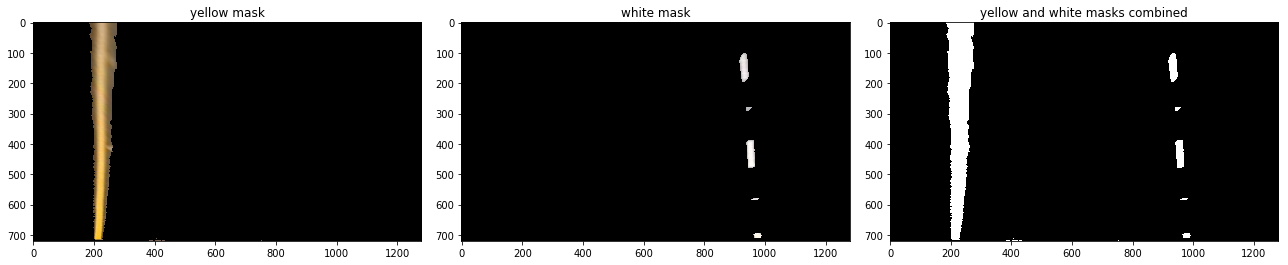

In [11]:
def yellow_lines(img):
    image = np.copy(img)
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    #yellow_hsv_low  = np.array([ 15,  100,  100])
    #yellow_hsv_high = np.array([ 35, 255, 255])
    yellow_hsv_low  = np.array([ 10,  70,  100])
    yellow_hsv_high = np.array([ 35, 255, 255])
    mask = color_mask(hsv, yellow_hsv_low, yellow_hsv_high)
    result = cv2.bitwise_and(image, image, mask= mask)
    return result, mask

def white_lines(img):
    image = np.copy(img)
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    #white_hsv_low  = np.array([ 0,   0,   205])
    #white_hsv_high = np.array([ 255,  30, 255])
    white_hsv_low  = np.array([ 0,   0,   180])
    white_hsv_high = np.array([ 180,  25, 255])
    mask = color_mask(hsv, white_hsv_low, white_hsv_high)
    result = cv2.bitwise_and(image, image, mask= mask)
    return result, mask

yellow_lines_binary, yellow_mask = yellow_lines(unwarp_img)
white_lines_binary, white_mask = white_lines(unwarp_img)
lane_mask = cv2.bitwise_or(yellow_mask, white_mask)

# plot and save image
images_to_plot = [yellow_lines_binary, white_lines_binary, lane_mask]
titles_to_plot = ['yellow mask', 'white mask', 'yellow and white masks combined']
out_file = "yellow_white_mask.png"
plot_images(rows=1, cols=3, images_to_plot=images_to_plot, titles_to_plot=titles_to_plot, out_file=out_file, cmap=[None,None,'gray'])

## 5. Gradient Thresholding

### 5.1 SobelX and SobelY

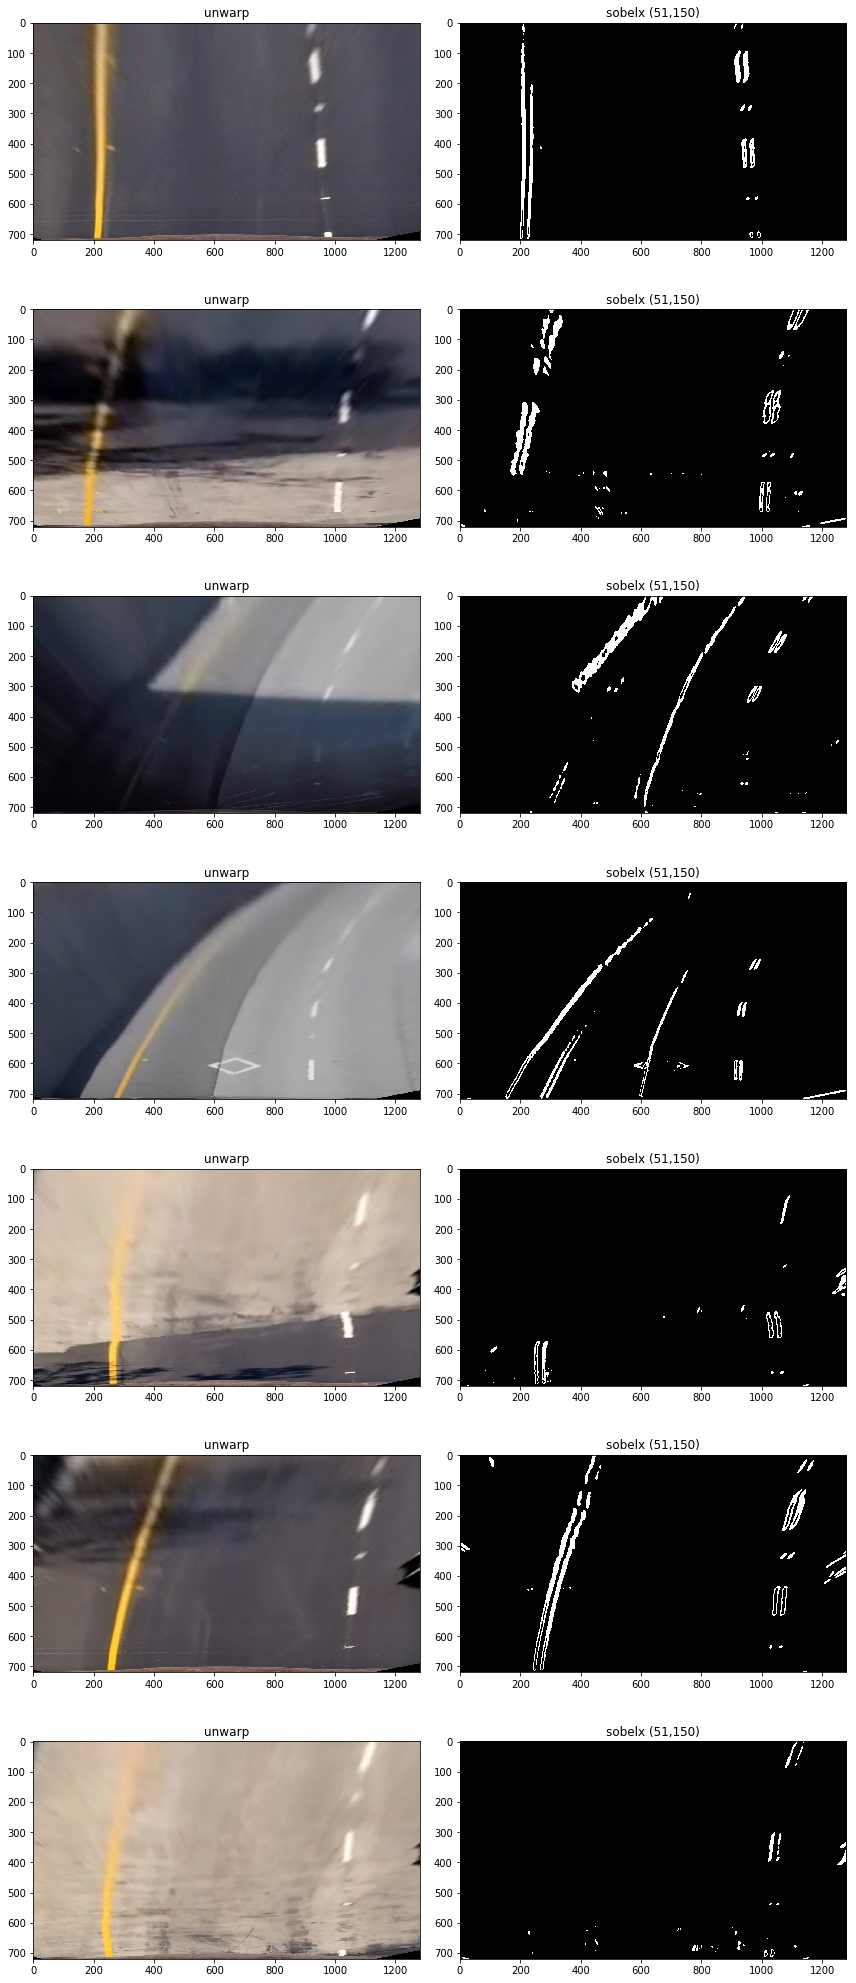

In [12]:
def build_lookup_table(inv_gamma):
    return np.array([((i / 255) ** inv_gamma) * 255 for i in range(256)]).astype(np.uint8)

def gamma_corrected(img, gamma):
    if gamma == 0:
        return np.zeros(img.shape)
    lookup_table = build_lookup_table(1 / gamma)
    return cv2.LUT(img, lookup_table)

def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
        
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def apply_filter(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    out = cv2.GaussianBlur(gray,(5,5),0)
    #kernel = np.ones((5,5),np.float32)/25
    #out = gamma_corrected(gray, 1.5)
    #out = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)
    #out = cv2.medianBlur(gray,3)
    #out = cv2.filter2D(gray,-1,kernel)
    #clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    #out = clahe.apply(gray)
    #out = cv2.equalizeHist(gray)
    #out = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    #out = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,23,4)
    return out

def updateSobel(orient, kernel, thresh_min, thresh_max):
    images_to_plot = []
    titles_to_plot = []
    cmaps_to_plot = []
    for idx in range(len(samples_unwarp)):
        sample_unwarp = samples_unwarp[idx]
        sample_gray_filtered = apply_filter(sample_unwarp)
        sample_gray_filtered_sobelx = abs_sobel_thresh(sample_gray_filtered, orient=orient, sobel_kernel=kernel, thresh=(thresh_min, thresh_max))
        images_to_plot.append(sample_unwarp)
        images_to_plot.append(sample_gray_filtered_sobelx)
        titles_to_plot.append('unwarp')
        titles_to_plot.append('sobel{} ({},{})'.format(orient, thresh_min, thresh_max))
        cmaps_to_plot.append(None)
        cmaps_to_plot.append('gray')
        
    # plot and save image
    out_file = "gradient_sobel{}.png".format(orient)
    plot_images(rows=len(sample_filename_list), cols=2, images_to_plot=images_to_plot, titles_to_plot=titles_to_plot, out_file=out_file, cmap=cmaps_to_plot)

interact(updateSobel,
         orient=['x', 'y'],
         kernel=(1,31,2),
         thresh_min=(0,255),
         thresh_max=(0,255))

In [13]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    absgraddir = np.arctan2(abs_sobely, abs_sobelx)
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

### 5.3 SobelMag Thresholding

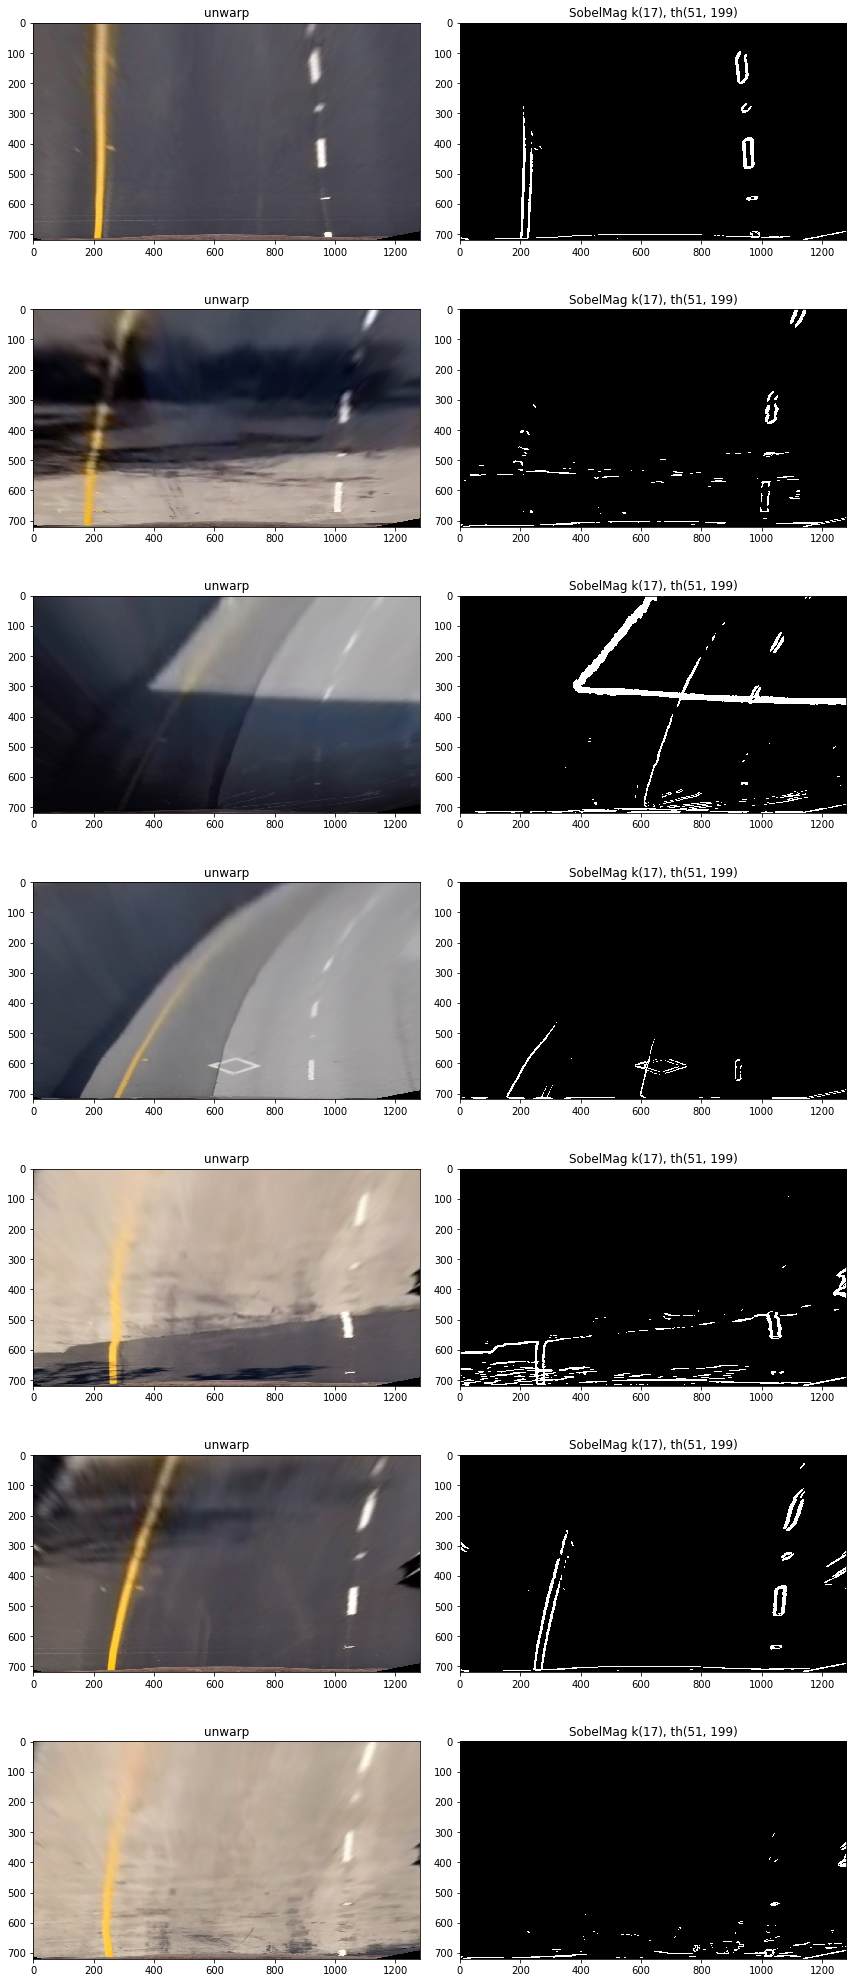

In [14]:
def updateSobelMag(ksize, thresh_min, thresh_max):
    
    images_to_plot = []
    titles_to_plot = []
    cmaps_to_plot = []
    for idx in range(len(samples_unwarp)):
        sample_unwarp = samples_unwarp[idx]
        out = mag_thresh(sample_unwarp, sobel_kernel=ksize, mag_thresh=(thresh_min, thresh_max))
        images_to_plot.append(sample_unwarp)
        images_to_plot.append(out)
        titles_to_plot.append('unwarp')
        titles_to_plot.append('SobelMag k({}), th({}, {})'.format(ksize, thresh_min, thresh_max))
        cmaps_to_plot.append(None)
        cmaps_to_plot.append('gray')
    out_file = "gradient_sobelMag.png"
    plot_images(rows=len(sample_filename_list), cols=2, images_to_plot=images_to_plot, titles_to_plot=titles_to_plot, out_file=out_file, cmap=cmaps_to_plot)

interact(updateSobelMag, 
         ksize=(3,31,2),
         thresh_min=(0,255),
         thresh_max=(0,255))

### 5.4 Sobel Direction Thresholding

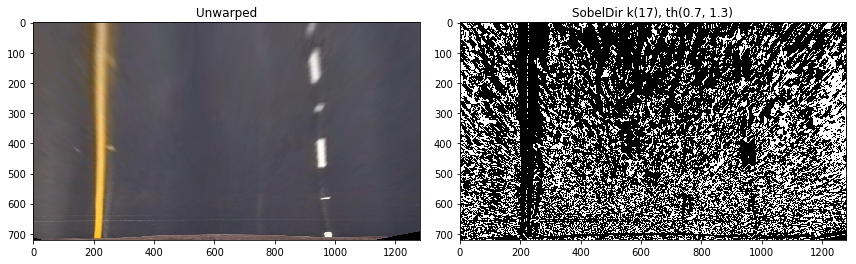

In [15]:
def updateSobelDir(ksize, thresh_min, thresh_max):
    out = dir_threshold(unwarp_img, sobel_kernel=ksize, thresh=(thresh_min, thresh_max))
    images_to_plot = [unwarp_img, out]
    titles_to_plot = ['Unwarped', 'SobelDir k({}), th({}, {})'.format(ksize, thresh_min, thresh_max)]
    out_file = "gradient_sobelDir.png"
    plot_images(rows=1, cols=2, images_to_plot=images_to_plot, titles_to_plot=titles_to_plot, out_file=out_file, cmap=[None,'gray'])

interact(updateSobelDir, 
         ksize=(3,31,2),
         thresh_min=(0.0,3.0),
         thresh_max=(0.0,3.0))

## 6. Pipeline

In [16]:
def pipeline(image):
    # Choose a Sobel kernel size
    ksize = 31 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(apply_filter(image), orient='x', sobel_kernel=ksize, thresh=(50, 150))
    yellow_lines_binary, yellow_mask = yellow_lines(image)
    white_lines_binary, white_mask = white_lines(image)
    lane_mask = cv2.bitwise_or(yellow_mask, white_mask)
    lane_mask = lane_mask/255.0
    
    combined = np.zeros_like(gradx)
    combined[((gradx == 1) | (lane_mask == 1))] = 1
    
    return combined

## 7. Test Images

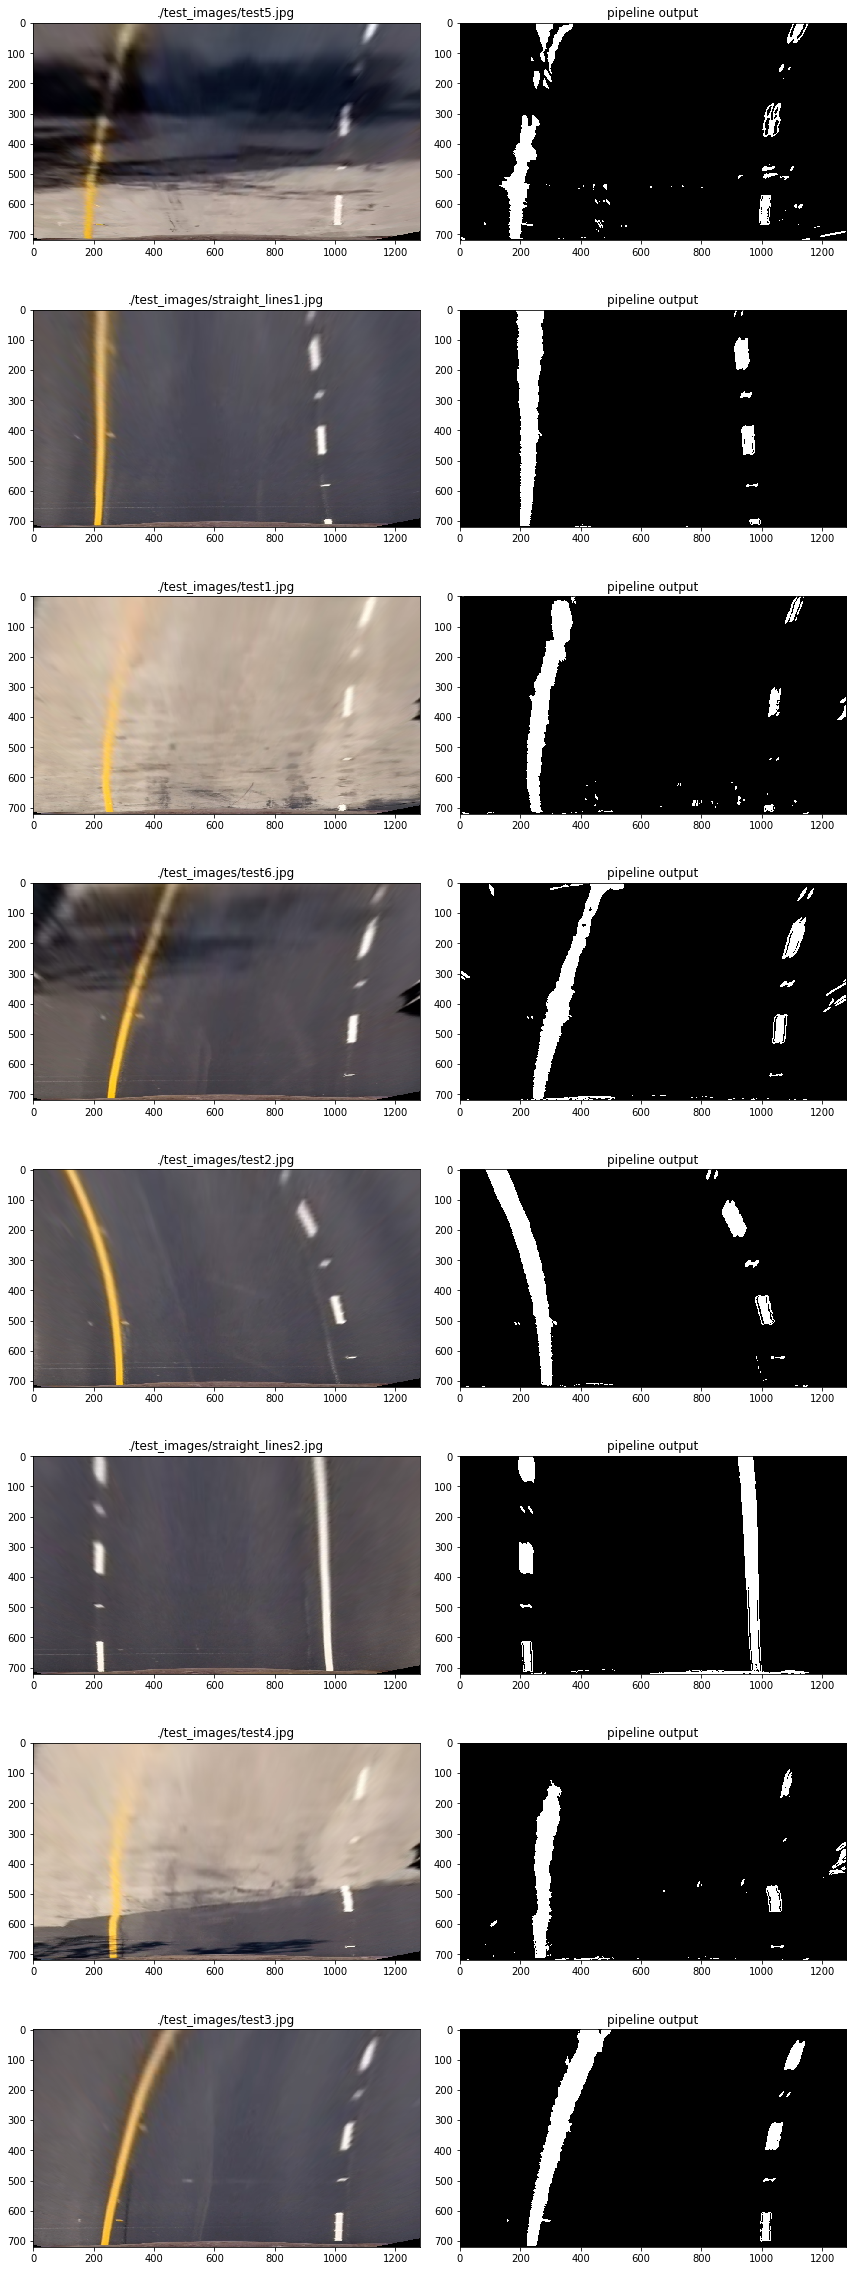

In [17]:
# try against all test images
images = glob.glob('./test_images/*.jpg')
    
images_to_plot = []
titles_to_plot = []
cmaps_to_plot = []
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    undist = undistort_image(img, mtx, dist)
    unwarp,M,Minv = unwarp_image(undist, src, dst)
    
    # process through pipeline
    img_out = pipeline(unwarp)

    images_to_plot.append(unwarp)
    titles_to_plot.append(fname)
    cmaps_to_plot.append(None)
    images_to_plot.append(img_out)
    titles_to_plot.append('pipeline output')
    cmaps_to_plot.append('gray')
out_file = "test_pipeline.png"
plot_images(rows=len(images), cols=2, images_to_plot=images_to_plot, titles_to_plot=titles_to_plot, out_file=out_file, cmap=cmaps_to_plot)

## 8. Locate the Lane Lines and Fit a Polynomial

### 8.1 Histogram

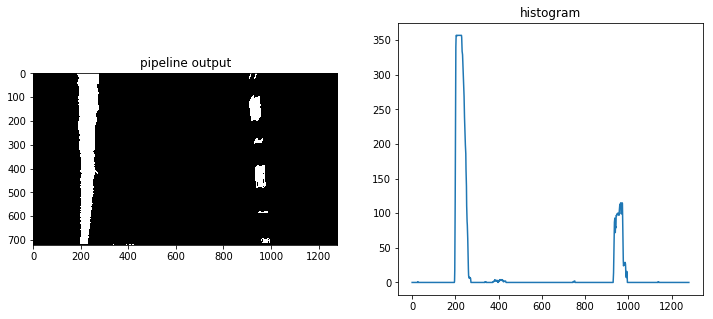

In [18]:
# ger outimage from pipeline
img_out = pipeline(unwarp_img)

# Assuming you have created a warped binary image called "binary_warped"
binary_warped = img_out

# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)

fig = plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(img_out, cmap='gray')
plt.title('pipeline output')
plt.subplot(122)
plt.plot(histogram)
plt.title('histogram')
fig.savefig('./output/pipeline_histogram.png')
plt.show()

In [19]:
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

print("Left base: {} Right base: {} Diff : {}".format(leftx_base, rightx_base, (rightx_base - leftx_base)))

Left base: 204 Right base: 964 Diff : 760


### 8.2 Sliding Window approach

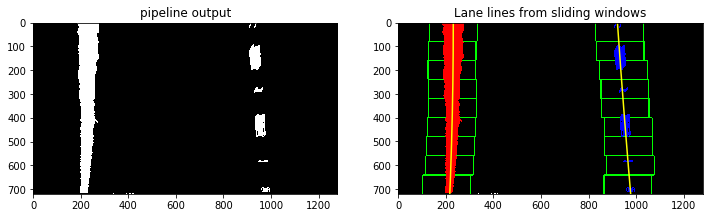

In [20]:
# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
fig = plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(img_out, cmap="gray")
plt.title("pipeline output")
plt.subplot(122)
plt.imshow(out_img)
plt.title("Lane lines from sliding windows")
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
fig.savefig('./output/sliding_window.png')
plt.show()

### 8.3 Left and Right Curvature (in pixels)¶

In [21]:
y_eval = np.max(lefty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print("Left curvature : {:.2f} px  Right curvature : {:.2f} px".format(left_curverad, right_curverad))
# Example values: 1926.74 1908.48

Left curvature : 17574.60 px  Right curvature : 44358.71 px


### 8.4 Left and Right Curvature (in meters)

In [22]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)

# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

# Now our radius of curvature is in meters
print("Left curvature : {:.2f} m  Right curvature : {:.2f} m".format(left_curverad, right_curverad))
# Example values: 632.1 m    626.2 m

Left curvature : 5758.44 m  Right curvature : 14413.95 m


### 8.5 Distance of the car from the center of the lane

In [23]:
img_center = binary_warped.shape[1] / 2
lane_center = (left_fit[-1] + right_fit[-1]) / 2
diff = lane_center - img_center
print("Distance from center : {:.2f} m".format(diff * xm_per_pix))

center_fit = (left_fit + right_fit) / 2
center_curverad = ((1 + (2 * center_fit[0] * y_eval * ym_per_pix + center_fit[1])**2)**1.5) / np.absolute(2 * center_fit[0])
print("Curvature : {:.2f} m ".format(center_curverad))

Distance from center : -0.34 m
Curvature : 58497.32 m 


### 8.6 Plot Selection Window

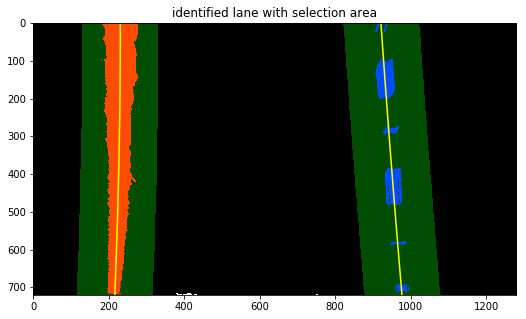

In [24]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
fig = plt.figure(figsize=(12,5))
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.title('identified lane with selection area')
fig.savefig('./output/lane_selected_area.png')
plt.show()

### 8.7 Overlay

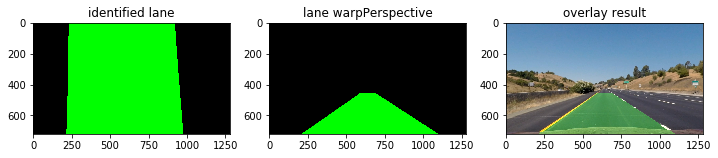

In [25]:
warped = img_out

# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (undist_img.shape[1], undist_img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
fig = plt.figure(figsize=(12,5))
plt.subplot(131)
plt.imshow(color_warp)
plt.title("identified lane")
plt.subplot(132)
plt.imshow(newwarp)
plt.title("lane warpPerspective")
plt.subplot(133)
plt.imshow(result)
plt.title("overlay result")
fig.savefig('./output/overlay.png')
plt.show()

## 9. Alternate approach to Sliding Window for finding lane lines

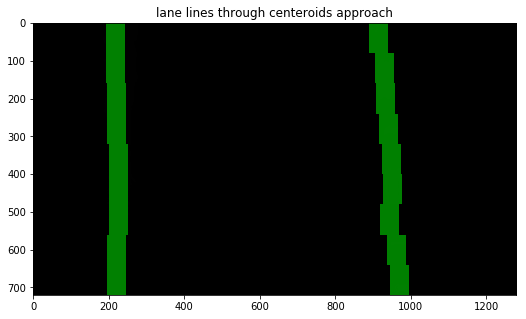

In [26]:
warped = img_out

# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))
        
    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channle 
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results 

# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
fig = plt.figure(figsize=(12,5))
plt.imshow(output)
plt.title('lane lines through centeroids approach')
fig.savefig('./output/centeriod.png')
plt.show()